# Yolo-KP4: pruning Yolo-KP by 4x
This tutorial demonstrates how to:
- pre-train,
- prune,
- finetune
  
starting from the previously published Yolo-KP model in order to obtain **Yolo-KP4** improving on accuracy (+2.5%), memory footprint (4x smaller) and synaptic operations (4x smaller).

Each step in the trainining is saved for easeness of use as torch network file.

We finally run inference on Loihi2 provided the resources are set up. for this last point We will use yolo_kp/run.ipyb script  inference of YOLO-KP SDNN (training example scripts here) on both CPU and Loihi 2 neurocore.ch

### Pre-train the full model on MSCoco

##### download or prepare the path for MSCOCO training set


- we assume you have downloaded MSCooco dataset in path_DATASET. When running the script below add ensure to add *-path* path_DATASET to set the dataset path
- Tune parameter *-b* according to the GPU RAM size available on your system. GPU splitting is not implemented explicitly.
- Tune parameter *-num_workers* according to the number of available CPUs on your system.


In [9]:
# Training Yolo-KP model on COCO dataset 
## the following command should be run on an external terminal. Below is an example of running code - It was briefly (purpously interrupted) run here to show the correct setup and output.


!python train_sdnnYolo.py -aug_prob 0.4 -b 12 -epoch 1000 -gpu 0 -lr 0.0005 -num_workers 24 -alpha_iou 0.8 -clip 1.0 -label_smoothing 0.03 -lambda_coord 2.0 -lambda_iou 2.25 -lambda_noobj 4.0 -lambda_obj 1.8  -lrf 0.01 -tgt_iou_thr 0.25 -track_iter 100 -warmup 40 -output_dir KP/COCO/ -strID preTrain -model single_head_KP -train -dataset COCO -threshold 0.1

loading dataset from /export/share/datasets/COCO2017
KP/COCO//Trained_preTrain202405050720
Using GPUs [0]
Classes output: 80
making net
loading net on cuda:0
module.init_model
optimizer
dataset
loading annotations into memory...
Done (t=13.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!
yolo_loss
stats
loss_tracker
train loop
epoch:   0%|                                           | 0/1000 [00:00<?, ?it/s]
Train: 0.0%|                                                            |0/9858 ^C
Exception ignored in: <function _releaseLock at 0x7f0dc5f43e20>
Traceback (most recent call last):
  File "/home/dbendaya/.venv/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


### Prune the KP model 

In the following we show how to load a preexisting torch weight file, we will then modify it by reducing the total size by 4x. 
The module accepts a 

*pruning_ratio* = x which can be also a non integer. The result will be a 2*x reduction in size and compute.

*pruning_method* = {'random', 'L1', 'L2'}, for pruning of the entire channels either randomly, sorting weights along their L1 or L2 norms and pruning the smallest. The L1 and L2 norms rationale is that larger norms contribute the most to the main direction of the weight vector on the postsynaptic neurons. The L1 and L2 norm of a two dimensionsional vector is illustrated below. The L1 norm tends to accumulate solutions around 0 and 1 and is a typical way to bring more weights to fall closer to zero compared to the L2 norm that assumes a circular relation among weight vectors.   

**NB** At this time we assume that the user will modify the former network config file/method to match the obtained weight size.
Please refer to the module output for consistency matching. Future releases tackle the automatic creation of the config netowrk file after pruning.

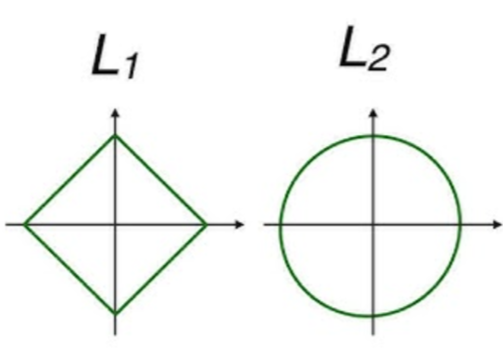

In [4]:
# load path for libraries
import torch
import sys
path = ['../YOLOsdnn/', '../.']
sys.path.extend(path)


##### CASE 1: when pruningFactor==2

here below we prune a model for which the model config method was already created (*pruningFactor*=2):

setting *logLevel*=2 the method will load the model script and test it against the resource evaluation routine:

- you can prune the model trained at the previous cell by placing: <br />
  ```saved_net_path = './KP/COCO/Trained_preTrain*DATE*/network.pt' ```
- or alternatively, you can prune the pre-trained (maxed out) model as in the next cell

the result will be saved in the same path of the provided *network.pt* file into a dedicated folder specifying pruning type and average pruning ratio per layer (point to this location for the following fine-tuning step)

**NB** with the provided path for the pre-trained network you will obtain exactly the same starting model if using:  <br />
  ```pruning_method = 'random'```  



In [7]:
# %load_ext autoreload
# %autoreload 2
from combined_heads import networkPruning
## prune the pre-trained model saved in the following path
networkPruning('./Pruning/trainedModels/Yolo_KP/network.pt', log_level=2, pruning_method='random', pruning_ratio=2)

anchors: [1, 3, 2] --> [1, 3, 2]
input_blocks.0.neuron.bias: [1] --> [1]
input_blocks.0.neuron.delta.threshold: [1] --> [1]
blocks.0.neuron.bias: [1] --> [1]
blocks.0.neuron.norm.running_mean: [16] --> [8]
blocks.0.neuron.delta.threshold: [1] --> [1]
blocks.0.synapse.weight_g: [16, 1, 1, 1, 1] --> [8, 1, 1, 1, 1]
blocks.0.synapse.weight_v: [16, 3, 3, 3, 1] --> [8, 3, 3, 3, 1]
blocks.1.neuron.bias: [1] --> [1]
blocks.1.neuron.norm.running_mean: [32] --> [16]
blocks.1.neuron.delta.threshold: [1] --> [1]
blocks.1.synapse.weight_g: [32, 1, 1, 1, 1] --> [16, 1, 1, 1, 1]
blocks.1.synapse.weight_v: [32, 16, 3, 3, 1] --> [16, 8, 3, 3, 1]
blocks.2.neuron.bias: [1] --> [1]
blocks.2.neuron.norm.running_mean: [64] --> [32]
blocks.2.neuron.delta.threshold: [1] --> [1]
blocks.2.synapse.weight_g: [64, 1, 1, 1, 1] --> [32, 1, 1, 1, 1]
blocks.2.synapse.weight_v: [64, 32, 3, 3, 1] --> [32, 16, 3, 3, 1]
blocks.3.neuron.bias: [1] --> [1]
blocks.3.neuron.norm.running_mean: [128] --> [64]
blocks.3.neuron.de

#### Case 2: when pruningFactor!=2
Here another example when *pruningFactor*!=2 - set ```logLevel = 1``` and manually define/modify a network model using ```models/short_*.py``` as a template, setting layer dimensions along the following output that indicates where to make the change.

In [22]:
# Example showing pruning on different pruiningMethod and pruningFactor

networkPruning('./trainedModels/Yolo_KP4/network.pt', log_level=1, pruning_method='L1', pruning_ratio=1.5)

anchors: [1, 3, 2] --> [1, 3, 2]
input_blocks.0.neuron.bias: [1] --> [1]
input_blocks.0.neuron.delta.threshold: [1] --> [1]
blocks.0.neuron.bias: [1] --> [1]
blocks.0.neuron.norm.running_mean: [8] --> [3]
blocks.0.neuron.delta.threshold: [1] --> [1]
blocks.0.synapse.weight_g: [8, 1, 1, 1, 1] --> [3, 1, 1, 1, 1]
blocks.0.synapse.weight_v: [8, 3, 3, 3, 1] --> [3, 3, 3, 3, 1]
blocks.1.neuron.bias: [1] --> [1]
blocks.1.neuron.norm.running_mean: [16] --> [6]
blocks.1.neuron.delta.threshold: [1] --> [1]
blocks.1.synapse.weight_g: [16, 1, 1, 1, 1] --> [6, 1, 1, 1, 1]
blocks.1.synapse.weight_v: [16, 8, 3, 3, 1] --> [6, 3, 3, 3, 1]
blocks.2.neuron.bias: [1] --> [1]
blocks.2.neuron.norm.running_mean: [32] --> [11]
blocks.2.neuron.delta.threshold: [1] --> [1]
blocks.2.synapse.weight_g: [32, 1, 1, 1, 1] --> [11, 1, 1, 1, 1]
blocks.2.synapse.weight_v: [32, 16, 3, 3, 1] --> [11, 6, 3, 3, 1]
blocks.3.neuron.bias: [1] --> [1]
blocks.3.neuron.norm.running_mean: [64] --> [22]
blocks.3.neuron.delta.thres

### Fine Tuning

You can skip this step if you want to use the pre-trained fine-tuned network stored in *./Pruning/trainedModels/Yolo_KP4/network.pt*

With the pruned network obtained earlier and after having setup BDD100K dataset in *dataset_path* add the also *-dataset_path dataset_path* when invoking the following command

You will notice that the model once loaded discards the output layer as it was pretrained on COCO that has 80 output classes. BDD100K has 11 output classes. The two models will mostly share the rest of the topology but for the output layer.  


In [11]:
# Fine-tuning Yolo-KP4 model on BDD100K dataset 
## the following command should be run on an external terminal. Below is an example of running code - It was briefly (purpously interrupted) run here to show the correct setup and output.

!python train_sdnnYolo.py -aug_prob 0.4 -b 12 -epoch 800 -gpu 0 -lr 0.0005 -num_workers 24 -alpha_iou 0.8 -clip 1.0 -label_smoothing 0.03 -lambda_coord 2.0 -lambda_iou 2.25 -lambda_noobj 4.0 -lambda_obj 1.8  -lrf 0.01 -tgt_iou_thr 0.25 -track_iter 100 -warmup 40 -output_dir KP4/BDD/ -strID fineTuned -model short_single_head_KP -train -dataset BDD100K -threshold 0.1 -load ./Pruning/trainedModels/Yolo_KP/random_pruning_by2.0/network.pt

loading dataset from /export/share/datasets/BDD100K/MOT2020/bdd100k
KP4/BDD//Trained_fineTuned202405051100
Using GPUs [0]
Classes output: 11
making net
loading net on cuda:0
Initializing model from ./Pruning/trainedModels/Yolo_KP/random_pruning_by2.0/network.pt
Model parameter heads.0.weight was not loaded.
module.init_model
optimizer
dataset
yolo_loss
stats
loss_tracker
train loop
epoch:   0%|                                            | 0/800 [00:00<?, ?it/s]
Train: 0.0%|                                                             |0/117 
epoch:   0%|                | 0/800 [02:19<?, ?it/s, |Trn:0.015 |Rate:0.16±0.14]
Train: 0.9%| |1/117 , Rate: [0.21, 0.09, 0.08, 0.08, 0.09, 0.10, 0.11, 0.11, 0.0^C

epoch:   0%|                | 0/800 [02:27<?, ?it/s, |Trn:0.015 |Rate:0.16±0.14]
Traceback (most recent call last):
  File "/home/dbendaya/_work_/ContinualLearning/tinyYolov3_lava/YOLOsdnn/yoloKP4/train_sdnnYolo.py", line 317, in <module>
    for i, (inputs, targets, bboxes) in enumerate

### inference

you can run inference using exactly the commands reported earlier by omitting the parameter *-train*